In [1]:
!git clone https://github.com/dalibra/MMD.git

Cloning into 'MMD'...


In [462]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [849]:
import numpy as np
import scipy as sp
from numpy import sqrt
from sklearn.metrics.pairwise import rbf_kernel

import matplotlib.pyplot as plt
from tqdm import tqdm

In [850]:
def MMD_3_Sample_Test(X,Y,Z,sigma=-1,SelectSigma=2,computeMMDs=False):
    '''Performs the relative MMD test which returns a test statistic for whether Y is closer to X or than Z.
    See http://arxiv.org/pdf/1511.04581.pdf
    The bandwith heuristic is based on the median heuristic (see Smola,Gretton).
    '''
    if(sigma<0):
        #Similar heuristics
        if(SelectSigma>1):
            siz=np.min((1000,X.shape[0]))
            sigma1=kernelwidthPair(X[0:siz],Y[0:siz]);
            sigma2=kernelwidthPair(X[0:siz],Z[0:siz]);
            sigma=(sigma1+sigma2)/2.
        else:
            siz=np.min((1000,X.shape[0]*3))
            Zem=np.r_[X[0:siz//3],Y[0:siz//3],Z[0:siz//3]]
            sigma=kernelwidth(Zem);

    Kyy = grbf(Y,Y,sigma)
    Kzz = grbf(Z,Z,sigma)
    Kxy = grbf(X,Y,sigma)
    Kxz = grbf(X,Z,sigma)
    Kyynd = Kyy-np.diag(np.diagonal(Kyy))
    Kzznd = Kzz-np.diag(np.diagonal(Kzz))
    m = Kxy.shape[0];
    n = Kyy.shape[0];
    r = Kzz.shape[0];    

    
    u_yy=np.sum(Kyynd)*( 1./(n*(n-1)) )
    u_zz=np.sum(Kzznd)*( 1./(r*(r-1)) )
    u_xy=np.sum(Kxy)/(m*n)
    u_xz=np.sum(Kxz)/(m*r)
    #Compute the test statistic
    t=u_yy - 2.*u_xy - (u_zz-2.*u_xz)
    Diff_Var,Diff_Var_z2,data=MMD_Diff_Var(Kyy,Kzz,Kxy,Kxz)

    pvalue=sp.stats.norm.cdf(-t/np.sqrt((Diff_Var)))
  #  pvalue_z2=sp.stats.norm.cdf(-t/np.sqrt((Diff_Var_z2)))
    tstat=t/sqrt(Diff_Var)
    
    if(computeMMDs):
        Kxx = grbf(X,X,sigma)
        Kxxnd = Kxx-np.diag(np.diagonal(Kxx))
        u_xx=np.sum(Kxxnd)*( 1./(m*(m-1)) )
        MMDXY=u_xx+u_yy-2.*u_xy
        MMDXZ=u_xx+u_zz-2.*u_xz
    else:
        MMDXY=None
        MMDXZ=None
    return pvalue,tstat,sigma,MMDXY,MMDXZ
    
def MMD_Diff_Var(Kyy,Kzz,Kxy,Kxz):
    '''
    Compute the variance of the difference statistic MMDXY-MMDXZ
    See http://arxiv.org/pdf/1511.04581.pdf Appendix for derivations
    '''
    m = Kxy.shape[0];
    n = Kyy.shape[0];
    r = Kzz.shape[0];
    
    
    Kyynd = Kyy-np.diag(np.diagonal(Kyy));
    Kzznd = Kzz-np.diag(np.diagonal(Kzz));
    
    u_yy=np.sum(Kyynd)*( 1./(n*(n-1)) );
    u_zz=np.sum(Kzznd)*( 1./(r*(r-1)) );
    u_xy=np.sum(Kxy)/(m*n);
    u_xz=np.sum(Kxz)/(m*r);
    
    #compute zeta1
    t1=(1./n**3)*np.sum(Kyynd.T.dot(Kyynd))-u_yy**2;
    t2=(1./(n**2*m))*np.sum(Kxy.T.dot(Kxy))-u_xy**2;
    t3=(1./(n*m**2))*np.sum(Kxy.dot(Kxy.T))-u_xy**2;
    t4=(1./r**3)*np.sum(Kzznd.T.dot(Kzznd))-u_zz**2;
    t5=(1./(r*m**2))*np.sum(Kxz.dot(Kxz.T))-u_xz**2;
    t6=(1./(r**2*m))*np.sum(Kxz.T.dot(Kxz))-u_xz**2;
    t7=(1./(n**2*m))*np.sum(Kyynd.dot(Kxy.T))-u_yy*u_xy;
    t8=(1./(n*m*r))*np.sum(Kxy.T.dot(Kxz))-u_xz*u_xy;
    t9=(1./(r**2*m))*np.sum(Kzznd.dot(Kxz.T))-u_zz*u_xz;
    
    zeta1=(t1+t2+t3+t4+t5+t6-2.*(t7+t8+t9)); 
    
    zeta2=(1/m/(m-1))*np.sum((Kyynd-Kzznd-Kxy.T-Kxy+Kxz+Kxz.T)**2)-(u_yy - 2.*u_xy - (u_zz-2.*u_xz))**2;
    
    
    data=dict({'t1':t1,
               't2':t2,
               't3':t3,
               't4':t4,
               't5':t5,
               't6':t6,
               't7':t7,
               't8':t8,
               't9':t9,
               'zeta1':zeta1,
               'zeta2':zeta2,
                }) 
    
    Var=(4.*(m-2)/(m*(m-1)))*zeta1;
    Var_z2=Var+(2./(m*(m-1)))*zeta2;

    return Var,Var_z2,data

def grbf(x1, x2, sigma):
    '''Calculates the Gaussian radial base function kernel'''
    n, nfeatures = x1.shape
    m, mfeatures = x2.shape
    
    k1 = np.sum((x1*x1), 1)
    q = np.tile(k1, (m, 1)).transpose()
    del k1
    
    k2 = np.sum((x2*x2), 1)
    r = np.tile(k2.T, (n, 1))
    del k2
    
    h = q + r
    del q,r
    
    # The norm
    h = h - 2*np.dot(x1,x2.transpose())
    h = np.array(h, dtype=float)
    
    return np.exp(-1.*h/(2.*pow(sigma,2)))
    
    
def kernelwidthPair(x1, x2):
    '''Implementation of the median heuristic. See Gretton 2012
       Pick sigma such that the exponent of exp(- ||x-y|| / (2*sigma2)),
       in other words ||x-y|| / (2*sigma2),  equals 1 for the median distance x
       and y of all distances between points from both data sets X and Y.
    '''
    n, nfeatures = x1.shape
    m, mfeatures = x2.shape
    
    k1 = np.sum((x1*x1), 1)
    q = np.tile(k1, (m, 1)).transpose()
    del k1
    
    k2 = np.sum((x2*x2), 1)
    r = np.tile(k2, (n, 1))
    del k2
    
    h= q + r
    del q,r
    
    # The norm
    h = h - 2*np.dot(x1,x2.transpose())
    h = np.array(h, dtype=float)
    
    mdist = np.median([i for i in h.flat if i])
    
    sigma = sqrt(mdist/2.0)
    if not sigma: sigma = 1
    
    return sigma

def kernelwidth(Zmed):
    '''Alternative median heuristic when we cant partition the points
    '''
    m= Zmed.shape[0]
    k1 = np.expand_dims(np.sum((Zmed*Zmed),axis=1),1)
    q = np.kron(np.ones((1, m)),k1)
    r = np.kron(np.ones((m, 1)),k1.T)
    del k1
    
    h= q + r
    del q,r
    
    # The norm
    h = h - 2.*Zmed.dot(Zmed.T)
    h = np.array(h, dtype=float)
    
    mdist = np.median([i for i in h.flat if i])
    
    sigma = sqrt(mdist/2.0)
    if not sigma: sigma = 1
    
    return sigma
    
    

def MMD_unbiased(Kxx,Kyy,Kxy):
#The estimate when distribution of x is not equal to y
    m = Kxx.shape[0]
    n = Kyy.shape[0]
    
    t1 = (1./(m*(m-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2./(m*n)) * np.sum(Kxy)
    t3 = (1./(n*(n-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

We construct three Gaussian distributions. Example:

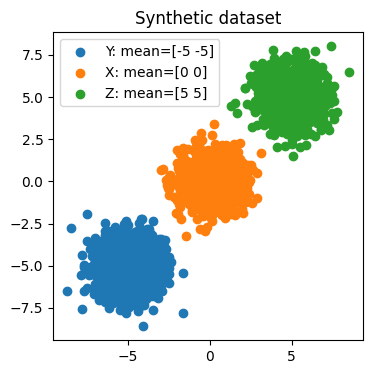

In [843]:
mu_Y = np.array([-5, -5])
mu_Z = np.array([5, 5])
mu_X = np.array([0, 0])
cov = np.eye(2)

X = np.random.multivariate_normal(mu_X, cov, 1000)
Y = np.random.multivariate_normal(mu_Y, cov, 1000)
Z = np.random.multivariate_normal(mu_Z, cov, 1000)

plt.figure(figsize=(4, 4))
plt.scatter(Y[:,0],Y[:,1], label='Y: mean=[-5 -5]')
plt.scatter(X[:,0],X[:,1],label='X: mean=[0 0]')
plt.scatter(Z[:,0],Z[:,1], label='Z: mean=[5 5]')
plt.title('Synthetic dataset')
plt.legend()
plt.show()

The question is whether the
similarity between X and Z is greater than the similarity between X and Y.

We vary $\mu_X$ such that $\mu_X = (1 - \gamma)\mu_Y + \gamma\mu_Z$

p-values of the relative similarity test for different distribution. When γ is
varying around 0.5, i.e., when MMD^2(F, X, Y ) is almost equal to MMD^2(F, X, Z), the p-values
quickly transition from 1 to 0, indicating strong discrimination of the test.

In [472]:
mu_Y = np.array([-5, -5])
mu_Z = np.array([5, 5])
cov = np.eye(2) 

gamma_values = np.linspace(0.1, 0.9, 41)

repeats_new = []
for i in tqdm(range(100)):
    p_values = []
    for gamma in gamma_values:
        mu_X = (1 - gamma) * mu_Y + gamma * mu_Z
        X = np.random.multivariate_normal(mu_X, cov, 100)
        Y = np.random.multivariate_normal(mu_Y, cov, 100)
        Z = np.random.multivariate_normal(mu_Z, cov, 100)

        pvalue,tstat,sigma,MMDXY,MMDXZ = MMD_3_Sample_Test(X, Y, Z, computeMMDs=True)
        p_values.append(pvalue)
    repeats_new.append(p_values)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\danil\AppData\Local\Temp\ipykernel_12644\1985744700.py:45: RuntimeWarning: invalid value encountered in sqrt
  pvalue=sp.stats.norm.cdf(-t/np.sqrt((Diff_Var)))
C:\Users\danil\AppData\Local\Temp\ipykernel_12644\1985744700.py:47: RuntimeWarning: invalid value encountered in sqrt
  tstat=t/sqrt(Diff_Var)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


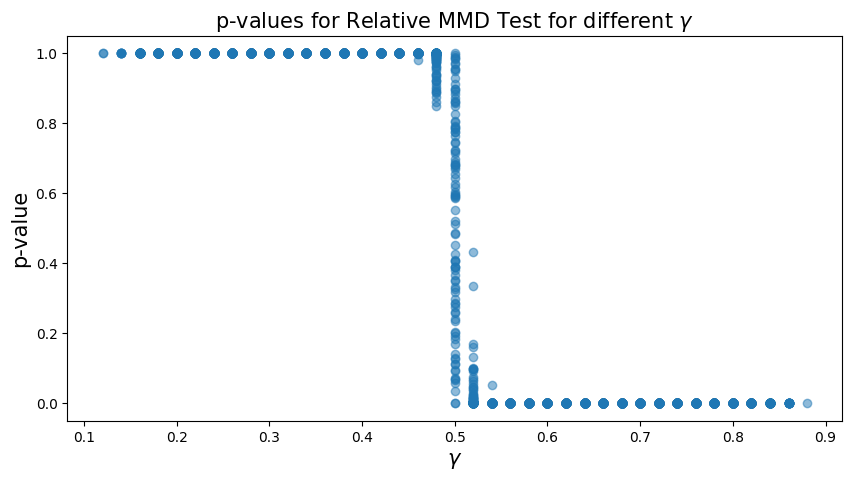

In [473]:
plt.figure(figsize=(10, 5))
for i in repeats_new:
    plt.scatter(gamma_values, i, label='p-values', color='tab:blue', alpha=0.5)
plt.xlabel(r'$\gamma$', size=15)
plt.ylabel('p-value', size=15)
plt.title(r'p-values for Relative MMD Test for different $\gamma$', size=15)
plt.show()

Next figure shows an empirical scatter plot of
the pairs of MMD statistics along with a 2σ iso-curve of the estimated distribution

In [833]:
gamma = 0.5
mu_Y = np.array([-5, -5])
mu_Z = np.array([5, 5])
num_sample = 250

values = []
for i in tqdm(range(200)):
    mu_X = (1 - gamma) * mu_Y + gamma * mu_Z
    X = np.random.multivariate_normal(mu_X, cov, num_sample)
    Y = np.random.multivariate_normal(mu_Y, cov, num_sample)
    Z = np.random.multivariate_normal(mu_Z, cov, num_sample)

    MMDXY,MMDXZ,data = get_mmd_data(X, Y, Z, computeMMDs=True)
    


    values.append([MMDXY,MMDXZ, data])
values = np.array(values)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.24it/s]


In [822]:
values[0][2]

{'t1': -0.005986219759263056,
 't2': 0.009667143876149725,
 't3': 0.009229371597961972,
 't4': -0.005992063677847659,
 't5': 0.008709093592189299,
 't6': 0.009683192978807598,
 't7': -0.001093072662183392,
 't8': -0.009460373408068823,
 't9': -0.0013326461287319624,
 'zeta1': 0.04908270300596623,
 'zeta2': 0.10970288146998101}

In [834]:
val_list = np.array([list(val.values()) for val in values[:, 2]])

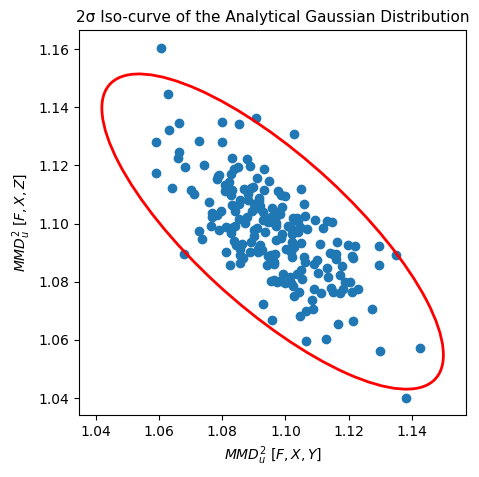

In [826]:
plt.figure(figsize=(5, 5))

mean = [np.mean(values[:,0]), np.mean(values[:,1])]
cov_ = np.array([[np.mean(val_list[:, 0:3], axis=0).sum()+np.mean(val_list[:, 6], axis=0), np.mean(val_list[:, 7], axis=0)],
                [np.mean(val_list[:, 7], axis=0), np.mean(val_list[:, 3:6], axis=0).sum()+np.mean(val_list[:, 8], axis=0)]])/np.sqrt(num_sample)

plt.scatter(values[:,0], values[:,1], label='p-values', color='tab:blue')
plt.xlabel(r'$MMD^2_u$ $[F, X, Y ]$')

plt.ylabel(r'$MMD^2_u$ $[F, X, Z ]$')
plt.title('')

lambda_, v = np.linalg.eig(cov_)
lambda_ = np.sqrt(lambda_)
ell = Ellipse(xy=(mean[0], mean[1]),
              width=lambda_[1]*4, height=lambda_[0]*4,
              angle=np.rad2deg(np.arccos(v[0, 0])))

ell.set_facecolor('none')
ell.set_edgecolor('red')
ell.set_linewidth(2)

# Add the iso-curve to the plot
plt.gca().add_patch(ell)
# plt.axis('equal')  # Equal scaling on both axes
plt.title('2σ Iso-curve of estimated Gaussian distribution', size=11)
plt.show()

plt.show()

Actually in the paper the values are positively correlated, but there were no code and theoretical calculations for all these experements, and we obtained different result.

Also we want the derived test to be well calibrated, and on this slide we show that. A calibrated test should output a uniform distribution of p-values when the two MMD distances are equal. Here you can see  empirical distributions of p-values for our case from later Gaussian distibutions of X,Y and Z.

In [621]:
gamma = 0.5

p_values_simtest = []
for i in tqdm(range(1000)):
    mean = np.random.uniform(0.1,23)
    mu_Y = np.array([-mean, -mean])
    mu_Z = np.array([mean, mean])
    mu_X = (1 - gamma) * mu_Y + gamma * mu_Z
    X = np.random.multivariate_normal(mu_X, cov, 5000)
    Y = np.random.multivariate_normal(mu_Y, cov, 5000)
    Z = np.random.multivariate_normal(mu_Z, cov, 5000)

    pvalue,tstat,sigma,MMDXY,MMDXZ = MMD_3_Sample_Test(X, Y, Z, computeMMDs=True)
    p_values_simtest.append(pvalue)
    
p_values_simtest = np.array(p_values_simtest)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:05:46<00:00, 11.15s/it]


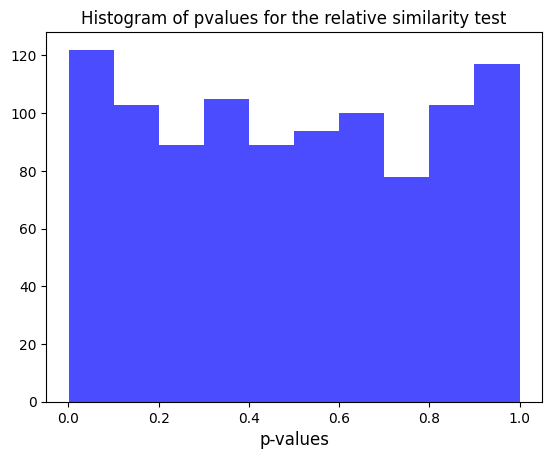

In [842]:
plt.hist(p_values_simtest, bins=10, density=False, alpha=0.7, color='blue')

plt.title('Histogram of pvalues for the relative similarity test')
plt.xlabel('p-values', size=12);

Analogically, for a given significance level α, the false positive rate should be equal to α. The empirical false positive rates for varying α are shown in this Figure, which further demonstrates the proper calibration of the test.

In [623]:
p_values_simtest = p_values_simtest[~np.isnan(p_values_simtest)]
p_values_simtest.shape

(1000,)

In [624]:
alpha_levels = np.linspace(0.01, 1, 21)
alpha_levels

array([0.01  , 0.0595, 0.109 , 0.1585, 0.208 , 0.2575, 0.307 , 0.3565,
       0.406 , 0.4555, 0.505 , 0.5545, 0.604 , 0.6535, 0.703 , 0.7525,
       0.802 , 0.8515, 0.901 , 0.9505, 1.    ])

In [625]:
false_positive_rates = [np.mean(p_values_simtest < alpha) for alpha in alpha_levels]

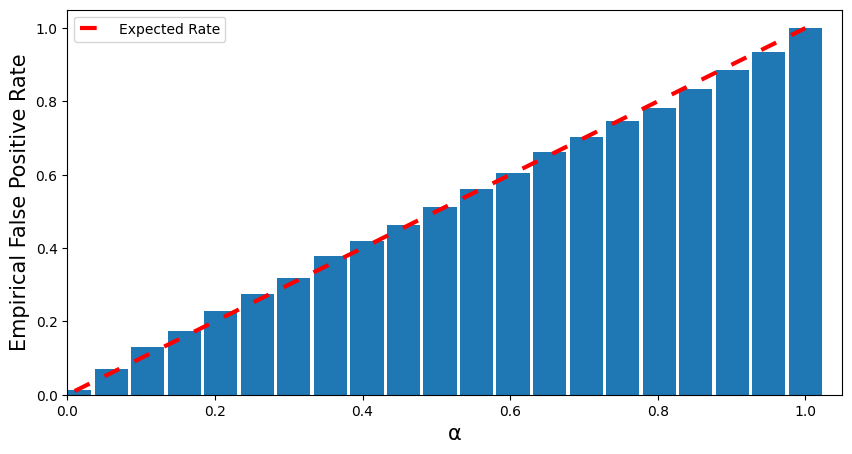

In [626]:
plt.figure(figsize=(10, 5))
plt.bar(alpha_levels, false_positive_rates, 0.045)
plt.plot(alpha_levels, alpha_levels, 'r--', label='Expected Rate', dashes=(4, 4.), linewidth=3)

# plt.title('Empirical False Positive Rates for Varying α')
plt.xlabel('α', size=15)
plt.ylabel('Empirical False Positive Rate', size=15)
plt.xlim(0, 1.05)
plt.legend()

# Save the figure
plt.show()

And these are again empirical distibutions of p-values, but already for sets of normal distributions with different orientations (), we can see that here p-values are aswell uniformly distributed, as it should be in well calibrated test.

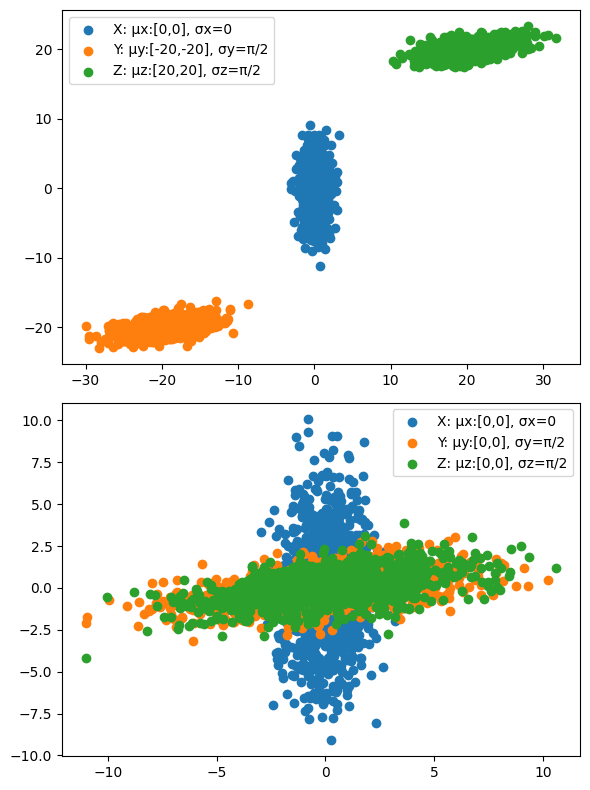

In [872]:
mu_x = np.array([0, 0])
mu_y = np.array([-20, -20])
mu_z = np.array([20, 20])

sigma_x = 0
sigma_y = np.pi / 2
sigma_z = np.pi / 2
cov_x = np.array([[1, sigma_x], [sigma_x, 10]])
cov_y = np.array([[10, sigma_y], [sigma_y, 1]])
cov_z = np.array([[10, sigma_z], [sigma_z, 1]])
size = 1000

x = np.random.multivariate_normal(mu_x, cov_x, size)
y = np.random.multivariate_normal(mu_y, cov_y, size)
z = np.random.multivariate_normal(mu_z, cov_z, size)

x2 = np.random.multivariate_normal(mu_x, cov_x, size)
y2 = np.random.multivariate_normal(mu_x, cov_y, size)
z2 = np.random.multivariate_normal(mu_x, cov_z, size)

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

axs[0].scatter(x[:, 0], x[:, 1], label='X: μx:[0,0], σx=0')
axs[0].scatter(y[:, 0], y[:, 1], label='Y: μy:[-20,-20], σy=π/2')
axs[0].scatter(z[:, 0], z[:, 1], label='Z: μz:[20,20], σz=π/2')
axs[0].legend()
# axs[0].set_title('(c) Illustration of the synthetic data with different means and orientations for X, Y, and Z.')

axs[1].scatter(x2[:, 0], x2[:, 1], label='X: μx:[0,0], σx=0')
axs[1].scatter(y2[:, 0], y2[:, 1], label='Y: μy:[0,0], σy=π/2')
axs[1].scatter(z2[:, 0], z2[:, 1], label='Z: μz:[0,0], σz=π/2')
axs[1].legend()
# axs[1].set_title('(e) Illustration of the synthetic data with different orientations for X, Y, and Z.')

plt.tight_layout()
plt.show()

In [865]:
gamma = 0.5

p_values_simtest2 = []
p_values_simtest3 = []
for i in tqdm(range(1000)):
    size = 1000
    x = np.random.multivariate_normal(mu_x, cov_x, size)
    y = np.random.multivariate_normal(mu_y, cov_y, size)
    z = np.random.multivariate_normal(mu_z, cov_z, size)

    x2 = np.random.multivariate_normal(mu_x, cov_x, size)
    y2 = np.random.multivariate_normal(mu_x, cov_y, size)
    z2 = np.random.multivariate_normal(mu_x, cov_z, size)

    pvalue2,_,_,_,_ = MMD_3_Sample_Test(x, y, z)
    pvalue3,_,_,_,_ = MMD_3_Sample_Test(x2, y2, z2)
    p_values_simtest2.append(pvalue2)
    p_values_simtest3.append(pvalue3)
    
p_values_simtest2 = np.array(p_values_simtest2)
p_values_simtest3 = np.array(p_values_simtest3)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:09<00:00,  1.15s/it]


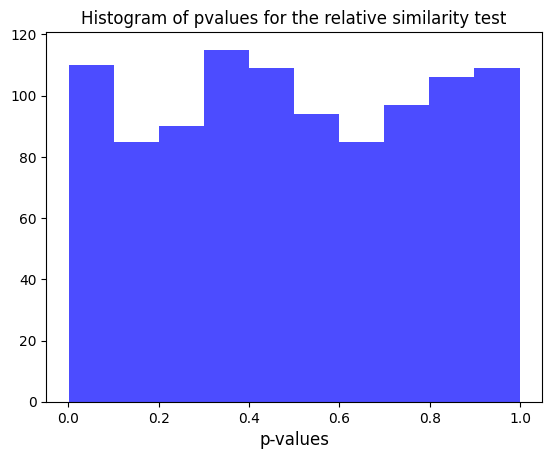

In [869]:
plt.hist(p_values_simtest2, bins=10, density=False, alpha=0.7, color='blue')

plt.title('Histogram of pvalues for the relative similarity test')
plt.xlabel('p-values', size=12);

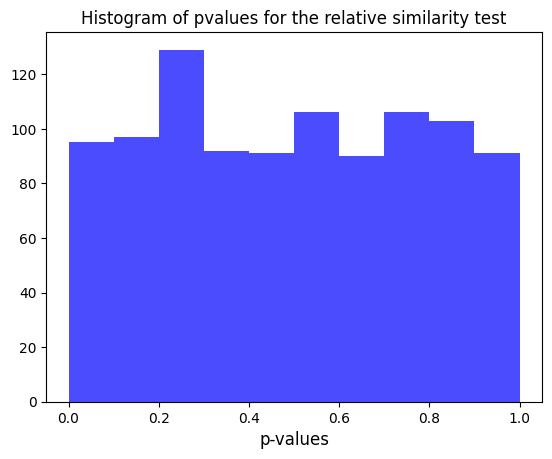

In [871]:
plt.hist(p_values_simtest3, bins=10, density=False, alpha=0.7, color='blue')

plt.title('Histogram of pvalues for the relative similarity test')
plt.xlabel('p-values', size=12);